# 迁移学习微调训练图像分类模型
# Migration learning fine-tuning training image classification models
在自己的图像分类数据集上，使用ImageNet预训练图像分类模型初始化，改动分类层，迁移学习微调训练
Initialization of pre-trained image classification model using ImageNet on its own image classification dataset, alteration of classification layers, migration learning fine-tuning training

## 设置matplotlib中文字体
## Setting matplotlib Chinese fonts

In [6368]:
# # windows操作系统
# plt.rcParams['font.sans-serif']=['SimHei']  # 用来正常显示中文标签 
# plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号

In [6369]:
# Mac操作系统，参考 https://www.ngui.cc/51cto/show-727683.html
# 下载 simhei.ttf 字体文件
# !wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/SimHei.ttf

In [6370]:
# Linux操作系统，例如 云GPU平台：https://featurize.cn/?s=d7ce99f842414bfcaea5662a97581bd1
# 如果遇到 SSL 相关报错，重新运行本代码块即可

# !wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/SimHei.ttf -O /home/sha/software/miniconda3/envs/py37_torch191/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/SimHei.ttf
# !rm -rf /home/featurize/.cache/matplotlib

# import matplotlib
# import matplotlib.pyplot as plt
# matplotlib.rc("font",family='SimHei') # 中文字体
# plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号

In [6371]:
# path = ''
# for i in os.listdir('data/'):
#     print(i)
#     i

## 导入工具包
## Import Toolkit

In [6372]:
import sys
import time
import os

import numpy as np
from tqdm import tqdm

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

# 忽略烦人的红色提示/Ignore Ignore annoying red alerts
import warnings
warnings.filterwarnings("ignore")

def writePrint():        
    output_content = open(r"record.txt", "a")# 写入记事本/Write to Notepad
    sys.stdout = output_content

## 获取计算硬件
## Get computing hardware

In [6373]:
# 有 GPU 就用 GPU，没有就用 CPU/ If you have a GPU, use a GPU. If you don't, use a CPU.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

## 图像预处理
## Image preprocessing

In [6374]:
from torchvision import transforms

# 训练集图像预处理：缩放裁剪、图像增强、转 Tensor、归一化
# Training set image preprocessing: zoom crop, image enhancement, to Tensor, normalization
train_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                     ])

# 测试集图像预处理-RCTN：缩放、裁剪、转 Tensor、归一化
# Test set image preprocessing-RCTN: Scale, Crop, Turn Tensor, Normalize
test_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
                                    ])

## 载入图像分类数据集
## Load an image classification dataset

In [6375]:
# 数据集文件夹路径/Dataset folder path
dataset_dir = 'r>rc'#'R_split'R-250

In [6376]:
# 训练和测试集名/Practice and test set names
train = 'tra'
val = 'val'

In [6377]:
train_path = os.path.join(dataset_dir, train)
test_path = os.path.join(dataset_dir, val)
print('训练集路径', train_path)
print('测试集路径', test_path)

In [6378]:
from torchvision import datasets

# 载入训练集/Load training set
train_dataset = datasets.ImageFolder(train_path, train_transform)

# 载入测试集/Load Test Set
test_dataset = datasets.ImageFolder(test_path, test_transform)

In [6379]:
print('训练集图像数量', len(train_dataset))
print('类别个数', len(train_dataset.classes))
print('各类别名称', train_dataset.classes)

In [6380]:
print('测试集图像数量', len(test_dataset))
print('类别个数', len(test_dataset.classes))
print('各类别名称', test_dataset.classes)

## 类别和索引号 一一对应
## Category and index numbers correspond one to one ##

In [6381]:
# 各类别名称/Name of each category
class_names = train_dataset.classes
n_class = len(class_names)

In [6382]:
class_names

['The-Eiffel-Tower',
 'The-Great-Wall-of-China',
 'airplane',
 'ant',
 'anvil',
 'apple',
 'asparagus',
 'axe',
 'banana',
 'barn',
 'basketball',
 'bat',
 'bear',
 'bicycle',
 'blueberry',
 'brain',
 'bridge',
 'butterfly',
 'cake',
 'camel',
 'camera',
 'campfire',
 'candle',
 'canoe',
 'car',
 'castle',
 'cat',
 'church',
 'circle',
 'clock',
 'cloud',
 'crab',
 'cups',
 'dog',
 'dragon',
 'drums',
 'duck',
 'elephant',
 'envelope',
 'firetruck',
 'fish',
 'flower',
 'flying-saucer',
 'frog',
 'garden',
 'guitar',
 'harp',
 'hat',
 'hockey-puck',
 'horse',
 'hot-air-balloon',
 'hourglass',
 'kangaroo',
 'lantern',
 'leaf',
 'light-bulb',
 'lighthouse',
 'lightning',
 'lion',
 'lobster',
 'lollipop',
 'map',
 'microphone',
 'monkey',
 'moon',
 'mountain',
 'mouse',
 'mushroom',
 'ocean',
 'octopus',
 'onion',
 'owl',
 'panda',
 'parrot',
 'pear',
 'penguin',
 'piano',
 'pig',
 'rabbit',
 'rain',
 'rhinoceros',
 'river',
 'sailboat',
 'saxophone',
 'sheep',
 'skateboard',
 'skull',
 '

In [6383]:
# 映射关系：类别 到 索引号/Mapping relationship: category to index number
train_dataset.class_to_idx

{'The-Eiffel-Tower': 0,
 'The-Great-Wall-of-China': 1,
 'airplane': 2,
 'ant': 3,
 'anvil': 4,
 'apple': 5,
 'asparagus': 6,
 'axe': 7,
 'banana': 8,
 'barn': 9,
 'basketball': 10,
 'bat': 11,
 'bear': 12,
 'bicycle': 13,
 'blueberry': 14,
 'brain': 15,
 'bridge': 16,
 'butterfly': 17,
 'cake': 18,
 'camel': 19,
 'camera': 20,
 'campfire': 21,
 'candle': 22,
 'canoe': 23,
 'car': 24,
 'castle': 25,
 'cat': 26,
 'church': 27,
 'circle': 28,
 'clock': 29,
 'cloud': 30,
 'crab': 31,
 'cups': 32,
 'dog': 33,
 'dragon': 34,
 'drums': 35,
 'duck': 36,
 'elephant': 37,
 'envelope': 38,
 'firetruck': 39,
 'fish': 40,
 'flower': 41,
 'flying-saucer': 42,
 'frog': 43,
 'garden': 44,
 'guitar': 45,
 'harp': 46,
 'hat': 47,
 'hockey-puck': 48,
 'horse': 49,
 'hot-air-balloon': 50,
 'hourglass': 51,
 'kangaroo': 52,
 'lantern': 53,
 'leaf': 54,
 'light-bulb': 55,
 'lighthouse': 56,
 'lightning': 57,
 'lion': 58,
 'lobster': 59,
 'lollipop': 60,
 'map': 61,
 'microphone': 62,
 'monkey': 63,
 'moon':

In [6384]:
# 映射关系：索引号 到 类别/Mapping relationship: index number to category
idx_to_labels = {y:x for x,y in train_dataset.class_to_idx.items()}

In [6385]:
idx_to_labels

{0: 'The-Eiffel-Tower',
 1: 'The-Great-Wall-of-China',
 2: 'airplane',
 3: 'ant',
 4: 'anvil',
 5: 'apple',
 6: 'asparagus',
 7: 'axe',
 8: 'banana',
 9: 'barn',
 10: 'basketball',
 11: 'bat',
 12: 'bear',
 13: 'bicycle',
 14: 'blueberry',
 15: 'brain',
 16: 'bridge',
 17: 'butterfly',
 18: 'cake',
 19: 'camel',
 20: 'camera',
 21: 'campfire',
 22: 'candle',
 23: 'canoe',
 24: 'car',
 25: 'castle',
 26: 'cat',
 27: 'church',
 28: 'circle',
 29: 'clock',
 30: 'cloud',
 31: 'crab',
 32: 'cups',
 33: 'dog',
 34: 'dragon',
 35: 'drums',
 36: 'duck',
 37: 'elephant',
 38: 'envelope',
 39: 'firetruck',
 40: 'fish',
 41: 'flower',
 42: 'flying-saucer',
 43: 'frog',
 44: 'garden',
 45: 'guitar',
 46: 'harp',
 47: 'hat',
 48: 'hockey-puck',
 49: 'horse',
 50: 'hot-air-balloon',
 51: 'hourglass',
 52: 'kangaroo',
 53: 'lantern',
 54: 'leaf',
 55: 'light-bulb',
 56: 'lighthouse',
 57: 'lightning',
 58: 'lion',
 59: 'lobster',
 60: 'lollipop',
 61: 'map',
 62: 'microphone',
 63: 'monkey',
 64: 'mo

In [6386]:
# 保存为本地的 npy 文件/Save as local npy file
np.save('R_idx_to_labels.npy', idx_to_labels)
np.save('R_labels_to_idx.npy', train_dataset.class_to_idx)

## 定义数据加载器DataLoader
## Define the data loader DataLoader

In [6387]:
from torch.utils.data import DataLoader

In [6388]:
BATCH_SIZE = 32

# 训练集的数据加载器/Data loader for the training set
train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=4
                         )

# 测试集的数据加载器/Data Loader for Test Sets
test_loader = DataLoader(test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=4
                        )

## 查看一个batch的图像和标注
## View images and annotations for a batch

In [6389]:
# DataLoader 是 python生成器，每次调用返回一个 batch 
# DataLoader is a python generator that returns a batch per call 
images, labels = next(iter(train_loader))

In [6390]:
images.shape

torch.Size([32, 3, 224, 224])

In [6391]:
labels

tensor([112,  28,  68,   9,  24,  77,  34,  57,   9,  83,  19,  59,  86,  40,
         67,  37,  77,  18,   8, 113,  71,  45,  32, 102,   2,  34,  54,   4,
        113,  29, 103,  33])

## 可视化一个batch的图像和标注
## Visualize a batch of images and annotations

In [6392]:
# 将数据集中的Tensor张量转为numpy的array数据类型
# Convert the Tensor tensor in a dataset to numpy's array datatype
images = images.numpy()

In [6393]:
images[5].shape

(3, 224, 224)

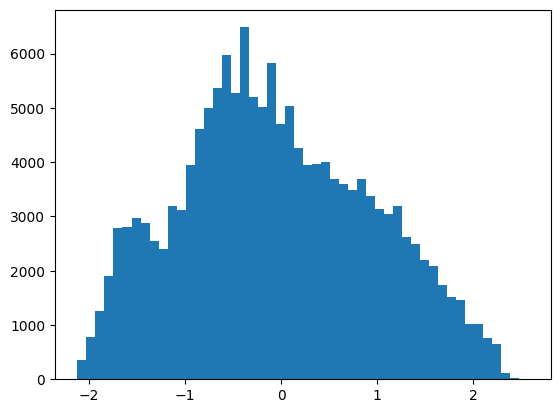

In [6394]:
plt.hist(images[5].flatten(), bins=50)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'label:28')

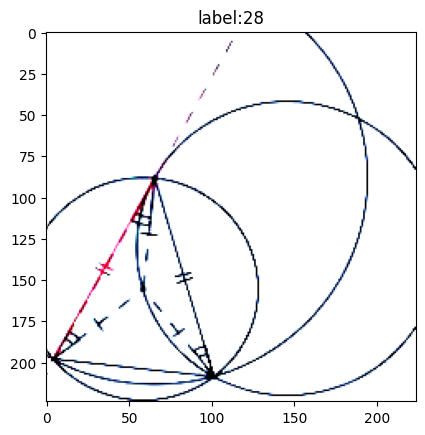

In [6395]:
# batch 中经过预处理的图像
# pre-processed images in batch
idx = 1
plt.imshow(images[idx].transpose((1,2,0))) # 转为(224, 224, 3)
plt.title('label:'+str(labels[idx].item()))

In [6396]:
label = labels[idx].item()

In [6397]:
label

28

In [6398]:
pred_classname = idx_to_labels[label]

In [6399]:
pred_classname

'circle'

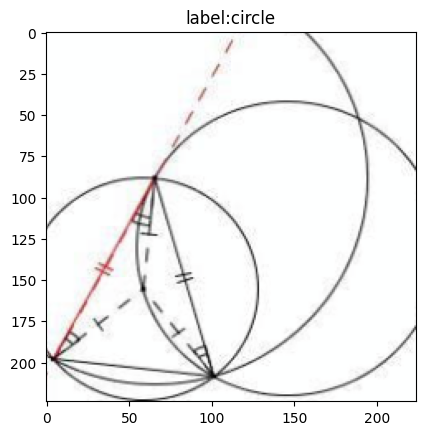

In [6400]:
# 原始图像/Original image
idx = 1
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(np.clip(images[idx].transpose((1,2,0)) * std + mean, 0, 1))
plt.title('label:'+ pred_classname)
plt.show()

## 导入训练需使用的工具包
## Toolkit to be used for importing training

In [6401]:
from torchvision import models
import torch.optim as optim

## 选择迁移学习训练方式
## Choosing a migration learning training method

斯坦福CS231N【迁移学习】中文精讲：https://www.bilibili.com/video/BV1K7411W7So

斯坦福CS231N【迁移学习】官方笔记：https://cs231n.github.io/transfer-learning/

### 选择一：只微调训练模型最后一层（全连接分类层）
### Option 1: Fine-tune only the last layer of the training model (the fully connected classification layer)

In [6402]:
# model = models.resnet18(pretrained=True) # 载入预训练模型Load pre-trained model

# 修改全连接层，使得全连接层的输出与当前数据集类别数对应/Modify the full connectivity layer
# 新建的层默认 requires_grad=True
model.fc = nn.Linear(model.fc.in_features, n_class)

In [6403]:
model.fc

Linear(in_features=512, out_features=114, bias=True)

In [6404]:
# 只微调训练最后一层全连接层的参数，其它层冻结
# Only the parameters of the last fully connected layer of the training are fine-tuned, and the other layers are frozen
optimizer = optim.Adam(model.fc.parameters())

### 选择二：微调训练所有层
### Option 2: Fine-tune training of all layers

In [6405]:
# model = models.resnet18(pretrained=True) # 载入预训练模型/Load pre-trained model

# model.fc = nn.Linear(model.fc.in_features, n_class)

# optimizer = optim.Adam(model.parameters())

### 选择三：随机初始化模型全部权重，从头训练所有层
### Option 3: Randomly initialize all weights of the model and train all layers from scratch

In [6406]:
# model = models.resnet18(pretrained=False) # 只载入模型结构，不载入预训练权重参数

# model.fc = nn.Linear(model.fc.in_features, n_class)

# optimizer = optim.Adam(model.parameters())

## 
## Training configuration

In [6407]:
model = model.to(device)

# 交叉熵损失函数/Cross Entropy Loss Function
criterion = nn.CrossEntropyLoss() 

# 训练轮次 Epoch/Training rounds Epoch
EPOCHS = 20

## 模拟一个batch的训练
## Simulate the training of a batch

In [6408]:
# 获得一个 batch 的数据和标注/Get a batch of data and annotations
images, labels = next(iter(train_loader))
images = images.to(device)
labels = labels.to(device)

In [6409]:
# 输入模型，执行前向预测/Input model to perform forward prediction
outputs = model(images)

In [6410]:
# 获得当前 batch 所有图像的预测类别 logit 分数
# Get the predicted category logit scores for all images in the current batch
outputs.shape

torch.Size([32, 114])

In [6411]:
# 由 logit，计算当前 batch 中，每个样本的平均交叉熵损失函数值
# From logit, calculate the average cross-entropy loss function for each sample in the current batch.
loss = criterion(outputs, labels)

In [6412]:
# 反向传播“三部曲”/# Reverse communication "trilogy"
optimizer.zero_grad() # 清除梯度/Clearing the gradient
loss.backward() # 反向传播/backward propagation
optimizer.step() # 优化更新/Optimization Updates

In [6413]:
# 获得当前 batch 所有图像的预测类别/Get the predicted categories for all images in the current batch
_, preds = torch.max(outputs, 1)

In [6414]:
preds

tensor([ 8, 45, 16, 20, 46,  8, 45, 79, 16, 45, 23, 79, 79, 16, 45, 79, 23,  8,
        45,  8, 92, 23, 45, 45, 89, 79, 45,  8, 45, 66,  0, 79],
       device='cuda:0')

In [6415]:
labels

tensor([ 99,  19,  35,  89,  40,  69,  71,  71,  24,  80,  85, 100,  88, 111,
         19,  27, 109,  30,  63,  64,  79,  88,   1,  94,  64,  69,  55, 113,
         14,  70,   4, 109], device='cuda:0')

## 运行完整训练
## Run the full training

In [ ]:
%%time
# 遍历每个 EPOCH/Iterate through each EPOCH
for epoch in tqdm(range(EPOCHS)):

    model.train()

    for images, labels in train_loader:  # 获得一个 batch 的数据和标注/Get a batch of data and annotations
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels) # 计算当前 batch 中，每个样本的平均交叉熵损失函数值
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
writePrint()
print(dataset_dir)

  0%|                                                                                                                | 0/20 [00:00<?, ?it/s]

## 在测试集上初步测试
## Initial testing on a test set

In [ ]:
%%time

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum()

    writePrint()
    print('测试集上的准确率为 {:.3f} %'.format(100 * correct / total))

## 保存模型
## Save the model

In [ ]:
torch.save(model, 'checkpoints/R_pytorch_1.pth')

## 参考文档
## Reference documentation

https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

https://www.bilibili.com/video/BV1qe4y1D7zD

https://www.bilibili.com/video/BV14J411X7Bb

https://www.bilibili.com/video/BV1w4411u7ay